In [1]:
# import 
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import os
from torch.utils.data import Dataset
from librosa.feature import melspectrogram
from torch.utils.data import DataLoader

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
def is_running_on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ and os.environ["KAGGLE_KERNEL_RUN_TYPE"] == "Interactive"
DATA_PATH = '/kaggle/input/dcase-aml/' if is_running_on_kaggle() else 'data/'
print('Running on Kaggle' if is_running_on_kaggle() else 'Running locally')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Running on Kaggle


In [2]:
# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


## Data Loading 


In [3]:
TRAIN_PATH = DATA_PATH + r"dev_data/dev_data/slider/train"
TEST_PATH = DATA_PATH +r"dev_data/dev_data/slider/test"

In [4]:
# Dataloader

class AudioDataset(Dataset):
    def __init__(self, data_path, train):
        self.data_path = data_path
        file_list = os.listdir(self.data_path)
        
        if train:
            self.labels = [0] * len(file_list)
        else:
            self.labels = [1 if el[0]=='a' else 0 for el in file_list]
        print(self.data_path)
        
        self.audios, self.srs= zip(*[librosa.load(os.path.join(self.data_path, path)) for path in os.listdir(self.data_path)])
        self.mfccs = [librosa.feature.mfcc(y=audio, sr=self.srs[0]) for audio in self.audios]
        self.s= melspectrogram(y=self.audios[0], sr=self.srs[0])
        print(self.s.shape)
        self.spectrograms = [melspectrogram(y=audio, sr=self.srs[0]) for audio in self.audios]
        print(self.spectrograms[0].shape)
        self.spectrograms_db = [librosa.amplitude_to_db(spec, ref=np.min) for spec in self.spectrograms]
        print(self.spectrograms_db[0].shape)
        
        
    def __len__(self):
        return len(os.listdir(self.data_path))
    

    def __getitem__(self, idx):
        audio = self.audios[idx]
        label = self.labels[idx]
        sr = self.srs[idx]
        mfcc = self.mfccs[idx]
        spec = self.spectrograms[idx]
        spec_db = self.spectrograms_db[idx]
        spec_db_flattened = spec_db.flatten()  # Flatten the spectrograms_db
        return spec_db_flattened, label

In [5]:
train_dataset = AudioDataset(data_path=TRAIN_PATH, train=True)
test_dataset = AudioDataset(data_path=TEST_PATH, train=False)
train_dataset.spectrograms[0].shape

/kaggle/input/dcase-aml/dev_data/dev_data/slider/train
(128, 431)
(128, 431)
(128, 431)
/kaggle/input/dcase-aml/dev_data/dev_data/slider/test
(128, 431)
(128, 431)
(128, 431)


(128, 431)

In [6]:
train_mean = np.mean(train_dataset.spectrograms_db, axis = 0)
#print(train_mean)
train_dev = np.std(train_dataset.spectrograms_db, axis = 0)
#print(train_dev)

train_dataset_s = (train_dataset.spectrograms_db - train_mean) / train_dev
# print(train_dataset_s)

print(len(train_dataset_s))
print(len(test_dataset))

batch_size = 4

train_loader = DataLoader(train_dataset_s, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_loader))
print(len(test_loader))

2370
1101
593
276


## Model 


In [7]:
import torch
import torch.nn as nn
import torch.nn.init as init


class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 20
        self.encoder = nn.Sequential(
            nn.Linear(128 * 431, 28 * 28),
            nn.ReLU(),
            #nn.Linear(64 * 200, 28 * 28),
            #nn.ReLU(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 30)
            #nn.ReLU(),
            #nn.Linear(36, 20)
        )
        
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 20 ==> 784
        self.decoder = nn.Sequential(
            #nn.Linear(20, 36),
            #nn.ReLU(),
            nn.Linear(30, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.ReLU(),
            nn.Linear(28 * 28, 128 * 431),
            #nn.ReLU(),
            #nn.Linear(64 * 200, 128 * 431),
            nn.Sigmoid()
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.normal_(module.weight, mean=0, std=0.01)
                if module.bias is not None:
                    init.zeros_(module.bias)

                    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [8]:
# Model Initialization
model = AE().to(device)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-4,
							weight_decay = 1e-8)


torch.Size([4, 128, 431])


In [20]:
for epoch in range(epochs):
    epoch_loss = []
    for batch in train_loader:
        
        specs = batch
        specs = specs.to(device)  # Move to GPU if available
    
        # Output of Autoencoder
        reconstructed = model(specs)

        # Calculating the loss function
        loss = loss_function(reconstructed, specs)

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        epoch_loss.append(loss.item())

    # Average loss for the epoch
    epoch_mean_loss = np.mean(epoch_loss)
    losses.append(epoch_mean_loss)
    
    outputs.append((epoch, specs, reconstructed))
    print(f"Loss for epoch {epoch} is {epoch_mean_loss}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x431 and 55168x784)

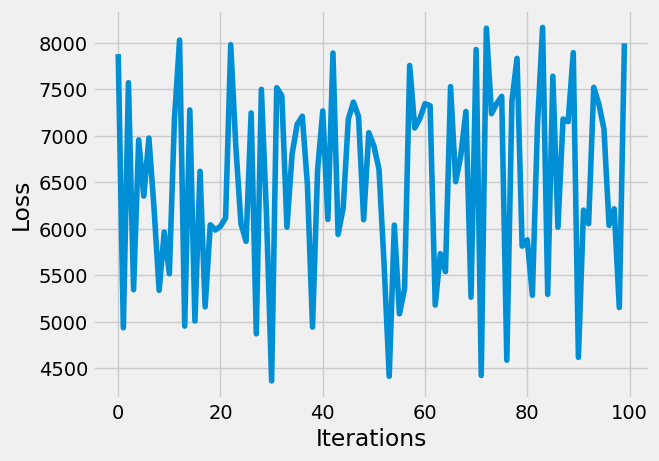

In [35]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot([losses_epoch.detach().cpu().numpy()])


In [ ]:
for i, item in enumerate(image):

   # Reshape the array for plotting
   item = item.reshape(-1, 28, 28)
   plt.imshow(item[0])

   for i, item in enumerate(reconstructed):
     item = item.reshape(-1, 28, 28)
     plt.imshow(item[0])
